In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import datetime as dt
import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import and_ , or_

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Creating inspector to find column and column datatypes
inspector = inspect(engine)

In [11]:
# Finding column names and datatypes for measurement class
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Finding column names and datatypes for station class
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [13]:
# Grabs the last date entry in the data table
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


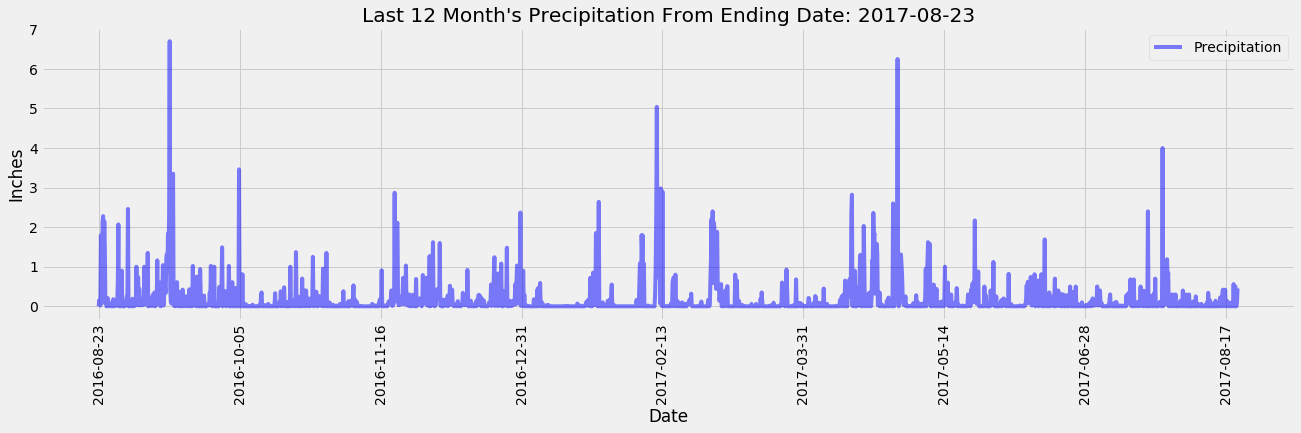

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the data and precipitation scores

last_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-22').\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df_last_year = pd.DataFrame(last_year, columns=["Date", "Precipitation"])
df_last_year_clean = df_last_year.dropna(how='any')
df_last_year_clean.set_index('Date', inplace=True)
df_last_year_clean.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
df_last_year_clean.plot(rot=90, figsize=(20,5), color='blue', alpha=0.5)
plt.title("Last 12 Month's Precipitation From Ending Date: 2017-08-23")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(["Precipitation"])
plt.show()


In [15]:
# Calculate the date 1 year ago from the last data point in the database

one_year_ago = datetime.date(2017, 8, 23) - datetime.timedelta(days=365)
print(f"Date a year from last data point is: {one_year_ago}")

Date a year from last data point is: 2016-08-23


In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data for the last 12 months

df_last_year_clean.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
no_station = session.query(Station.station).count()
print(f"There are {no_station} stations in this dataset")

There are 9 stations in this dataset


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_station = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

most_active_station_df = pd.DataFrame(most_active_station, columns=['Station Id', 'Count'])
most_active_station_df

,Station Id,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

session.query(Measurement.station, func.min(Measurement.tobs),
                                    func.max(Measurement.tobs),
                                    func.avg(Measurement.tobs)).\
                                    filter(Measurement.station == 'USC00519281').all() 


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [20]:
# Grab the last date entry fro station USC00519281
last = session.query(Measurement.date).order_by(Measurement.date.desc()).\
    filter(Measurement.station == 'USC00519281').first()
print(last)

('2017-08-18',)


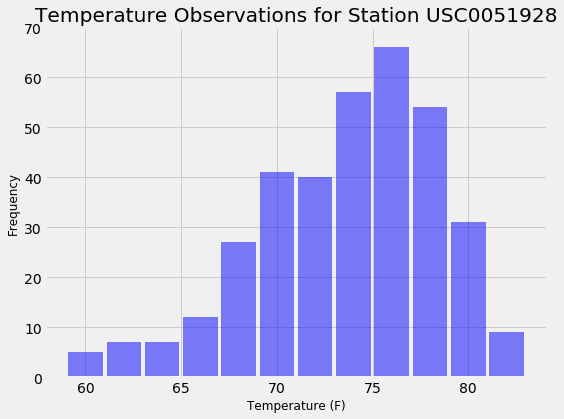

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temps_519281 = session.query(Measurement.date, Measurement.tobs).\
                            filter(Measurement.station == 'USC00519281').\
                            filter(Measurement.date > '2016-08-18').all()

temps_519281_df = pd.DataFrame(temps_519281, columns=["Date", "Temp"])

temps_519281_df.hist(column='Temp', bins=12, figsize=(8,6), color='blue', alpha=0.5, rwidth=0.9)
plt.ylim(0,70)
plt.xlabel("Temperature (F)", size=12)
plt.ylabel("Frequency", size=12)
plt.title("Temperature Observations for Station USC0051928")
plt.show()

## Optional Challenge Assignment

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = calc_temps('2016-04-01', '2016-04-10')
print(my_trip)

[(65.0, 72.83076923076923, 78.0)]


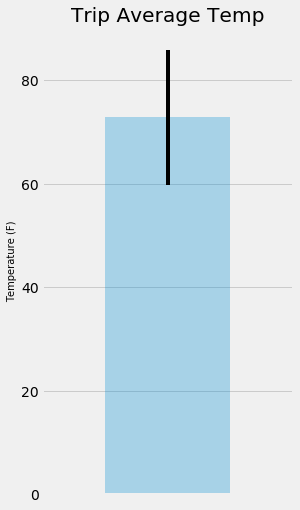

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

my_trip_df = pd.DataFrame(my_trip, columns=['Min', 'Average', 'Max'])
my_trip_avg_df = my_trip_df['Average']
min_max_temp = my_trip_df.iloc[0]['Max'] - my_trip_df.iloc[0]['Min']
my_trip_avg_df.plot(kind='bar', yerr=min_max_temp, alpha=0.3, figsize=(4,8))
plt.title("Trip Average Temp")
plt.ylabel('Temperature (F)', size=10)
plt.xticks([])
plt.show()

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station, func.sum(Measurement.prcp)).\
                    group_by(Measurement.station).\
                    filter(Measurement.date > '2016-04-01').\
                    filter(Measurement.date > '2016-04-05').\
                    order_by(func.sum(Measurement.prcp).desc()).all()


[('USC00516128', 223.42999999999995),
 ('USC00519281', 116.78000000000011),
 ('USC00513117', 77.75999999999995),
 ('USC00519523', 54.57999999999999),
 ('USC00514830', 43.77),
 ('USC00519397', 25.430000000000003),
 ('USC00517948', 6.32)]

In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = "2017-04-06"
end_date = "2017-04-10"

# Use the start and end date to create a range of dates
date = session.query(Measurement.date).\
            filter(Measurement.date >= '2017-04-06').\
            filter(Measurement.date <= '2017-04-10').\
            group_by(Measurement.date).all()

result_string = [d[0] for d in date]

# Strip off the year and save a list of %m-%d strings
# Need to give credit to stackoverflow for this code below:
stripped_date = list(map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").strftime("%m-%d"), result_string))


# Loop through the list of %m-%d strings and calculate the normals for each date
first_month_day = stripped_date[0]
last_month_day = stripped_date[-1]

daily_normals = session.query(Measurement.date, 
                       func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs)).\
                       filter(func.strftime("%m-%d", Measurement.date) >= first_month_day).\
                       filter(func.strftime("%m-%d", Measurement.date) <= last_month_day).\
                       group_by(func.strftime("%m-%d", Measurement.date)).all()

print(daily_normals)

[('2017-04-06', 67.0, 71.57142857142857, 77.0), ('2017-04-07', 63.0, 71.10526315789474, 78.0), ('2017-04-08', 66.0, 72.10526315789474, 77.0), ('2017-04-09', 62.0, 71.6140350877193, 78.0), ('2017-04-10', 64.0, 71.40350877192982, 79.0)]


In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
holiday_dates_df = pd.DataFrame(daily_normals, columns=["Date", "Min", "Average", "Max"])
holiday_dates_df.set_index('Date', inplace=True)
holiday_dates_df.sort_values("Date")

,Min,Average,Max
Date,,,
2017-04-06,67.0,71.571429,77.0
2017-04-07,63.0,71.105263,78.0
2017-04-08,66.0,72.105263,77.0
2017-04-09,62.0,71.614035,78.0
2017-04-10,64.0,71.403509,79.0


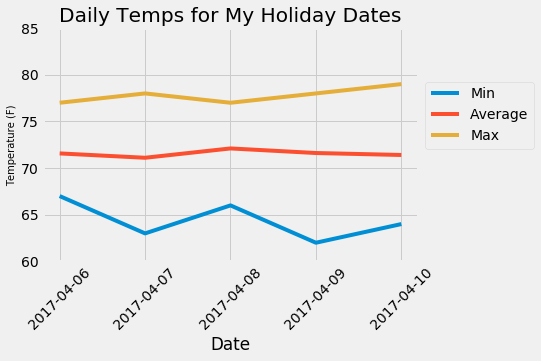

In [31]:
# Plot the daily normals as an area plot with `stacked=False`
holiday_dates_df.plot(stacked = False, rot=45, title = "Daily Temps for My Holiday Dates", 
                      ylim = (60,85)).legend(bbox_to_anchor=(1, 0.8))
plt.ylabel("Temperature (F)", size=10)
plt.show()
